INSTALLATIONS

In [1]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
!pip install torchtext==0.9.1
!pip install -U segmentation-models-pytorch
!pip install --upgrade albumentations

Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html
     |█████████████▌                  | 834.1MB 47.3MB/s eta 0:00:25tcmalloc: large alloc 1147494400 bytes == 0x561209ffe000 @  0x7f9d7e830615 0x561206d6bcdc 0x561206e4b52a 0x561206d6eafd 0x561206e5ffed 0x561206de2988 0x561206ddd4ae 0x561206d703ea 0x561206de27f0 0x561206ddd4ae 0x561206d703ea 0x561206ddf32a 0x561206e60e36 0x561206dde853 0x561206e60e36 0x561206dde853 0x561206e60e36 0x561206dde853 0x561206e60e36 0x561206ee33e1 0x561206e436a9 0x561206daecc4 0x561206d6f559 0x561206de34f8 0x561206d7030a 0x561206dde3b5 0x561206ddd7ad 0x561206d703ea 0x561206dde3b5 0x561206d7030a 0x561206dde3b5
     |█████████████████               | 1055.7MB 1.5MB/s eta 0:10:39tcmalloc: large alloc 1434370048 bytes == 0x56124e654000 @  0x7f9d7e830615 0x561206d6bcdc 0x561206e4b52a 0x561206d6eafd 0x561206e5ffed 0x561206de2988 0x561206ddd4ae 0x561206d703ea 0x561206de27f0 0x561206ddd4ae 0x561206d703ea 0x561206ddf32a 0x561206e60e36 0x561206dd

MOUNT DRIVE

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


SOME BASIC IMPORTS

In [3]:
# some basic imports
import math
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from random import sample
from PIL import Image
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau
import gc
import albumentations as A

UNZIP ADDITIONAL DATA

In [4]:
!unzip '/content/gdrive/My Drive/road_segmentation/toronto_light.zip'

Archive:  /content/gdrive/My Drive/road_segmentation/toronto_light.zip
   creating: toronto_light/
  inflating: toronto_light/.DS_Store  
  inflating: __MACOSX/toronto_light/._.DS_Store  
   creating: toronto_light/images/
   creating: toronto_light/groundtruth/
  inflating: toronto_light/images/test-img-6-6.png  
  inflating: __MACOSX/toronto_light/images/._test-img-6-6.png  
  inflating: toronto_light/images/test-img-8-9.png  
  inflating: __MACOSX/toronto_light/images/._test-img-8-9.png  
  inflating: toronto_light/images/test-img-4-4.png  
  inflating: __MACOSX/toronto_light/images/._test-img-4-4.png  
  inflating: toronto_light/images/test-img-5-11.png  
  inflating: __MACOSX/toronto_light/images/._test-img-5-11.png  
  inflating: toronto_light/images/test-img-2-2.png  
  inflating: __MACOSX/toronto_light/images/._test-img-2-2.png  
  inflating: toronto_light/images/test-img-7-14.png  
  inflating: __MACOSX/toronto_light/images/._test-img-7-14.png  
  inflating: toronto_light/imag

LOAD DATA FROM ZIP 

In [5]:
# unzip the dataset
try:
      !unzip '/content/gdrive/My Drive/road_segmentation/cil-road-segmentation-2021.zip'
      !mv training/training/* training
      !rm -rf training/training

except:
      print('Please upload a .zip file containing your datasets.')


Archive:  /content/gdrive/My Drive/road_segmentation/cil-road-segmentation-2021.zip
  inflating: mask_to_submission.py   
  inflating: sample_submission.csv   
  inflating: submission_to_mask.py   
  inflating: test_images/test_images/test_10.png  
  inflating: test_images/test_images/test_105.png  
  inflating: test_images/test_images/test_106.png  
  inflating: test_images/test_images/test_107.png  
  inflating: test_images/test_images/test_108.png  
  inflating: test_images/test_images/test_11.png  
  inflating: test_images/test_images/test_115.png  
  inflating: test_images/test_images/test_116.png  
  inflating: test_images/test_images/test_12.png  
  inflating: test_images/test_images/test_121.png  
  inflating: test_images/test_images/test_122.png  
  inflating: test_images/test_images/test_123.png  
  inflating: test_images/test_images/test_124.png  
  inflating: test_images/test_images/test_128.png  
  inflating: test_images/test_images/test_129.png  
  inflating: test_images/

In [6]:
#load data into np array function
def load_all_from_path(path):
    # loads all HxW .pngs contained in path as a 4D np.array of shape (n_images, H, W, 3)
    # images are loaded as floats with values in the interval [0., 1.]
    return np.stack([np.array(Image.open(f)) for f in sorted(glob(path + '/*.png'))]).astype(np.float32) / 255.

#load data
imgs  = load_all_from_path(os.path.join('training', 'images'))
masks = load_all_from_path(os.path.join('training', 'groundtruth'))


LOAD AND CONCATENATE ADDITIONAL DATA WITH ORIGINAL

In [7]:
imgs_toronto  = load_all_from_path(os.path.join('toronto_light', 'images'))
masks_toronto = load_all_from_path(os.path.join('toronto_light', 'groundtruth'))

In [8]:
imgs = np.concatenate((imgs,imgs_toronto), axis = 0)
masks = np.concatenate((masks,masks_toronto), axis = 0)

PRE TRAIN DATA AUGMENTATION

In [6]:
import albumentations as A
from skimage import transform


#RANDOM ROTATE IMAGE IN STEP OF 90, THEN EITHER FLIP VERTICAL OR HORIZONTAL AUGMENT x9
def augment_data_random(imgs,masks):
 
    new_imgs = []
    new_masks = []
    for x, y in zip(imgs, masks):
        transformed1 =  A.Rotate(limit = (0, 90), interpolation=1, border_mode=cv2.BORDER_REFLECT, p= 1)(image = x,mask =  y)
        transformed2 =  A.Rotate(limit = (90, 180), interpolation=1, border_mode=cv2.BORDER_REFLECT, p= 1)(image = x,mask =  y)
        transformed3 =  A.Rotate(limit = (180, 270), interpolation=1, border_mode=cv2.BORDER_REFLECT, p= 1)(image = x,mask =  y)
        transformed4 =  A.Rotate(limit = (270, 360), interpolation=1, border_mode=cv2.BORDER_REFLECT, p= 1)(image = x,mask = y)

        transformed5 = A.HorizontalFlip(p=1)(image = transformed1['image'],mask =   transformed1['mask'])
        transformed6 = A.VerticalFlip(p=1)(image = transformed2['image'],mask =   transformed2['mask'])
        transformed7 = A.HorizontalFlip(p=1)(image = transformed3['image'],mask =   transformed3['mask'])
        transformed8 = A.VerticalFlip(p=1)(image = transformed4['image'],mask =   transformed4['mask'])

        new_imgs.append(x)
        new_imgs.append(transformed1['image'])
        new_imgs.append(transformed2['image'])
        new_imgs.append(transformed3['image'])
        new_imgs.append(transformed4['image'])
        new_imgs.append(transformed5['image'])
        new_imgs.append(transformed6['image'])
        new_imgs.append(transformed7['image'])
        new_imgs.append(transformed8['image'])

        new_masks.append(y)
        new_masks.append(transformed1['mask'])
        new_masks.append(transformed2['mask'])
        new_masks.append(transformed3['mask'])
        new_masks.append(transformed4['mask'])
        new_masks.append(transformed5['mask'])
        new_masks.append(transformed6['mask'])
        new_masks.append(transformed7['mask'])
        new_masks.append(transformed8['mask'])

    return  np.asarray(new_imgs), np.asarray(new_masks )





#AUGMENTED IMAGES AND MASKS
augmented_imgs, augmented_masks = augment_data_random(imgs, masks)

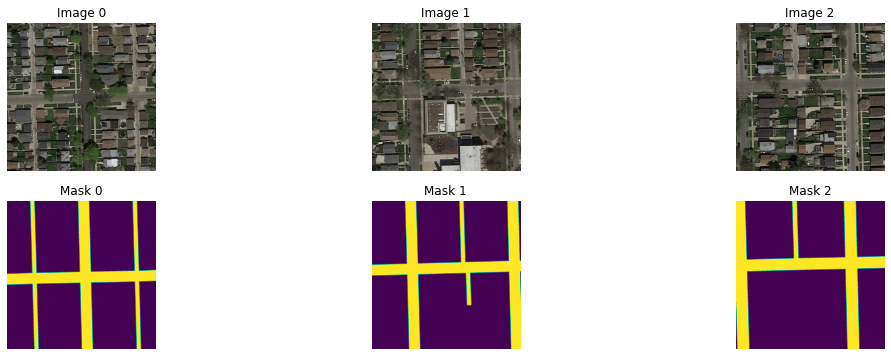

In [9]:
def show_first_n(imgs, masks, n=3):
    # visualizes the first n elements of a series of images and segmentation masks
    imgs_to_draw = min(n, len(imgs))
    fig, axs = plt.subplots(2, imgs_to_draw, figsize=(18.5, 6))
    for i in range(imgs_to_draw):
        axs[0, i].imshow(imgs[i])
        axs[1, i].imshow(masks[i])
        axs[0, i].set_title(f'Image {i}')
        axs[1, i].set_title(f'Mask {i}')
        axs[0, i].set_axis_off()
        axs[1, i].set_axis_off()
    plt.show()


show_first_n(imgs, masks)

PATCH COMPUTATION

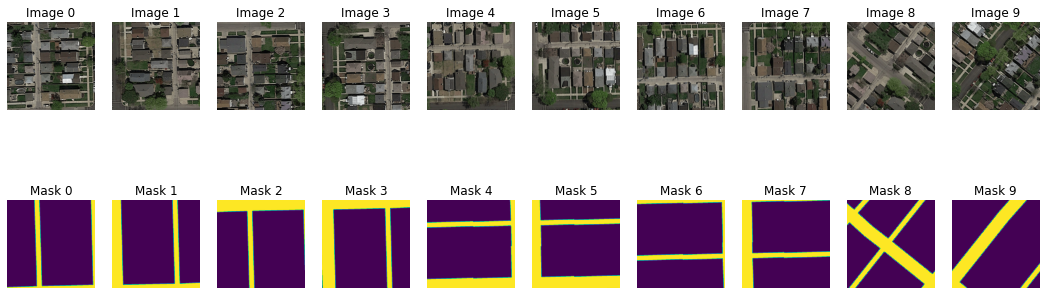

In [ ]:
# some constants
PATCH_SIZE = 200  # pixels per side of square patches
CUTOFF = 0.25  # minimum average brightness for a mask patch to be classified as containing road


#RETURNS LIST OF PATCHES AND LABELS FROM IMAGES
def image_to_patches(images, masks=None):
    # takes in a 4D np.array containing images and (optionally) a 4D np.array containing the segmentation masks
    # returns a 4D np.array with an ordered sequence of patches extracted from the image and (optionally) a np.array containing labels
    n_images = images.shape[0]  # number of images
    h, w = images.shape[1:3]  # shape of images
    assert (h % PATCH_SIZE) + (w % PATCH_SIZE) == 0  # make sure images can be patched exactly

    h_patches = h // PATCH_SIZE
    w_patches = w // PATCH_SIZE
    patches = images.reshape((n_images, h_patches, PATCH_SIZE, h_patches, PATCH_SIZE, -1))
    patches = np.moveaxis(patches, 2, 3)
    patches = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)
    if masks is None:
        return patches

    masks = masks.reshape((n_images, h_patches, PATCH_SIZE, h_patches, PATCH_SIZE, -1))
    masks = np.moveaxis(masks, 2, 3)
    labels = np.mean(masks, (-1, -2, -3)) > CUTOFF  # compute labels
    labels = labels.reshape(-1).astype(np.float32)
    masks = masks.reshape(-1, PATCH_SIZE, PATCH_SIZE)
    return patches, masks


def show_patched_image(patches, labels, h_patches=25, w_patches=25):
    # reorders a set of patches in their original 2D shape and visualizes them
    fig, axs = plt.subplots(h_patches, w_patches, figsize=(18.5, 18.5))
    for i, (p, l) in enumerate(zip(patches, labels)):
        # the np.maximum operation paints patches labeled as road red
        axs[i // w_patches, i % w_patches].imshow(np.maximum(p, np.array([l.item(), 0., 0.])))
        axs[i // w_patches, i % w_patches].set_axis_off()
    plt.show()



patches,patches_masks = image_to_patches(augmented_imgs, augmented_masks)

#show_patched_image(patches, patches_masks )
np.shape(patches_masks)
show_first_n(patches, patches_masks , n = 10)

TRAINING AND VALIDATION SPLIT

In [10]:
from sklearn.model_selection import train_test_split


train_data, val_data, train_masks, val_masks = train_test_split(imgs, masks, test_size=0.10, shuffle=True, random_state=42)

WEIGHT COMPUTATION FOR BALANCE

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#returns (1- sum_percentage_label_0_per_image/n_images), (1- sum_percentage_label_0_per_image/n_images)
def number_of_label_01(masks):
  labels_1 = 0
  labels_0 = 0
  for mask in masks:
    h, w = mask.shape
    label_1 = np.sum(mask, axis = None)
    label_0 = h*w - label_1
    labels_1 += label_1/(h*w)
    labels_0 += label_0/(h*w)
  return np.array([(1 - labels_0/masks.shape[0]), (1 - labels_1/masks.shape[0])])

#like sklearn wieght class balanced i guess
def balanced_weights(masks):
  labels_1 = 0
  labels_0 = 0
  n_samples = masks.shape[0]*masks.shape[1]*masks.shape[2]
  for mask in masks:
    h, w = mask.shape
    label_1 = np.sum(mask, axis = None)
    label_0 = h*w - label_1
    labels_1 += label_1
    labels_0 += label_0
  return  np.array([(n_samples/(2*labels_0)), (n_samples/(2*labels_1))])
  

#class_weights  = number_of_label_01(train_masks)
class_weights = balanced_weights(train_masks)
class_weights

array([0.61629553, 2.64969564])

MODEL 

DATASET 

In [11]:
def np_to_tensor(x, device):
    # allocates tensors from np.arrays
    if device == 'cpu':
        return torch.from_numpy(x).cpu().float()
    else:
        return torch.from_numpy(x).contiguous().pin_memory().to(device=device, non_blocking=True).float()



class ImageDataset(torch.utils.data.Dataset):
    # dataset class that deals with loading the data and making it available by index.

    def __init__(self, imgs, masks, path, device, use_patches=False, resize_to=(400, 400), transform=None, preprocessing = None):
        self.path = path
        self.device = device
        self.use_patches = use_patches
        self.resize_to=resize_to
        self.transform = transform
        self.preprocessing = preprocessing
        #self.x, self.y, self.n_samples = None, None, None
        #self._load_data()
        self.x, self.y = imgs, masks
        self.n_samples = len(self.x)
        if self.resize_to != (self.x.shape[1], self.x.shape[2]):  # resize images
            self.x = np.stack([cv2.resize(img, dsize=self.resize_to) for img in self.x], 0)
            self.y = np.stack([cv2.resize(mask, dsize=self.resize_to) for mask in self.y], 0)
        #self.x = np.moveaxis(self.x, -1, 1)  # pytorch works with CHW format instead of HWC


    def _load_data(self):  # not very scalable, but good enough for now
        self.x = load_all_from_path(os.path.join(self.path, 'images'))
        self.y = load_all_from_path(os.path.join(self.path, 'groundtruth'))
        if self.use_patches:  # split each image into patches
            self.x, self.y = image_to_patches(self.x, self.y)
        elif self.resize_to != (self.x.shape[1], self.x.shape[2]):  # resize images
            self.x = np.stack([cv2.resize(img, dsize=self.resize_to) for img in self.x], 0)
            self.y = np.stack([cv2.resize(mask, dsize=self.resize_to) for mask in self.y], 0)
        self.x = np.moveaxis(self.x, -1, 1)  # pytorch works with CHW format instead of HWC
        self.n_samples = len(self.x)


    def _preprocess(self, x, y):
        # to keep things simple we will not apply transformations to each sample,
        # but it would be a very good idea to look into preprocessing 
    
        if self.transform is not None:
            transformed = self.transform(image = x)
            x = transformed['image']
            y = transformed['mask']

        return x, y


    def __getitem__(self, item):
       # return self._preprocess(np_to_tensor(self.x[item], self.device), np_to_tensor(self.y[item], self.device))
      
         # apply augmentations
        if self.transform:
            sample = self.transform(image= self.x[item], mask= self.y[item])
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image= self.x[item], mask= self.y[item])
            image, mask = sample['image'], sample['mask']
            
        image = np.moveaxis(image, -1, 0)
        return (np_to_tensor(image, self.device), np_to_tensor(mask, self.device))


    def __len__(self):
        return self.n_samples





def show_val_samples(x, y, y_hat, segmentation=False):
    #y = np.stack([reverse_one_hot(img) for img in y], 0)
    #y_hat = np.stack([reverse_one_hot(img) for img in y_hat], 0)
    # training callback to show predictions on validation set
    imgs_to_draw = min(5, len(x))
    if x.shape[-2:] == y.shape[-2:]:  # segmentation
        fig, axs = plt.subplots(3, imgs_to_draw, figsize=(18.5, 12))
        for i in range(imgs_to_draw):
            axs[0, i].imshow(np.moveaxis(x[i], 0, -1))
            axs[1, i].imshow(np.concatenate([np.moveaxis(y_hat[i], 0, -1)] * 3, -1))
            axs[2, i].imshow(np.concatenate([np.moveaxis(y[i], 0, -1)]*3, -1))
            axs[0, i].set_title(f'Sample {i}')
            axs[1, i].set_title(f'Predicted {i}')
            axs[2, i].set_title(f'True {i}')
            axs[0, i].set_axis_off()
            axs[1, i].set_axis_off()
            axs[2, i].set_axis_off()
    else:  # classification
        fig, axs = plt.subplots(1, imgs_to_draw, figsize=(18.5, 6))
        for i in range(imgs_to_draw):
            axs[i].imshow(np.moveaxis(x[i], 0, -1))
            axs[i].set_title(f'True: {np.round(y[i]).item()}; Predicted: {np.round(y_hat[i]).item()}')
            axs[i].set_axis_off()
    plt.show()

TRAIN FUNCTION

In [12]:
def train(train_dataloader, eval_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs, patience, scheduler):
    # training loop
    logdir = './tensorboard/net'
    writer = SummaryWriter(logdir)  # tensorboard writer (can also log images)

    history = {}  # collects metrics at the end of each epoch

    max_val_patch_acc = 0
    epochs_no_improve = 0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        # initialize metric list
        metrics = {'loss': [], 'val_loss': []}
        for k, _ in metric_fns.items():
            metrics[k] = []
            metrics['val_'+k] = []

        pbar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}')
        # training
        model.train()
        for (x, y) in pbar:
            optimizer.zero_grad()  # zero out gradients
            gc.collect()
            y_hat = model(x)  # forward pass
            y = y.unsqueeze(1)
            loss = loss_fn(y_hat, y)
            loss.backward()  # backward pass
            optimizer.step()  # optimize weights

            # log partial metrics
            metrics['loss'].append(loss.item())
            for k, fn in metric_fns.items():
                metrics[k].append(fn(y_hat, y).item())
            pbar.set_postfix({k: sum(v)/len(v) for k, v in metrics.items() if len(v) > 0})

        # validation
        model.eval()
        with torch.no_grad():  # do not keep track of gradients
            for (x, y) in eval_dataloader:
                y_hat = model(x) # forward pass
                y = y.unsqueeze(1)
                loss = loss_fn(y_hat, y)
                
                # log partial metrics
                metrics['val_loss'].append(loss.item())
                for k, fn in metric_fns.items():
                    metrics['val_'+k].append(fn(y_hat, y).item())

        
        # summarize metrics, log to tensorboard and display
        history[epoch] = {k: sum(v) / len(v) for k, v in metrics.items()}
        for k, v in history[epoch].items():
          writer.add_scalar(k, v, epoch)
        print(' '.join(['\t- '+str(k)+' = '+str(v)+'\n ' for (k, v) in history[epoch].items()]))
        show_val_samples(x.detach().cpu().numpy(), y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())



        #scheduler for learning rate update
        scheduler.step( sum(metrics['val_loss']) / len(metrics['val_loss']))
        curr_lr = optimizer.param_groups[0]['lr']
        print('learning rate')
        print(curr_lr)



        #early stopping
        val_patch_acc = sum(metrics['val_patch_acc']) / len(metrics['val_patch_acc'])
        if val_patch_acc > max_val_patch_acc:
          #Saving the model
          #if min_loss > loss.item():
              #min_loss = loss.item()
          best_model = copy.deepcopy(model.state_dict())
          print('saving model')
          epochs_no_improve = 0
          max_val_patch_acc = val_patch_acc

        else:
          epochs_no_improve += 1
          print('val_patch_acc not improving')
          # Check early stopping condition
          if epochs_no_improve == patience:
              print('Early stopping!' )
              model.load_state_dict(best_model)
              break
        



    print('Finished Training')
    # plot loss curves
    plt.plot([v['loss'] for k, v in history.items()], label='Training Loss')
    plt.plot([v['val_loss'] for k, v in history.items()], label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

U-NET MODEL

In [13]:
class Block(nn.Module):
    # a repeating structure composed of two convolutional layers with batch normalization and ReLU activations
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1, padding_mode = 'reflect'),
                                   nn.PReLU(),
                                   nn.BatchNorm2d(out_ch),
                                   nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, padding=1, padding_mode = 'reflect'),
                                   nn.PReLU())

    def forward(self, x):
        return self.block(x)

        
class UNet(nn.Module):
    # UNet-like architecture for single class semantic segmentation.
    def __init__(self, chs=(3,64,128,256,512)):
        super().__init__()
        enc_chs = chs  # number of channels in the encoder
        dec_chs = chs[::-1][:-1]  # number of channels in the decoder
        self.enc_blocks = nn.ModuleList([Block(in_ch, out_ch) for in_ch, out_ch in zip(enc_chs[:-1], enc_chs[1:])])  # encoder blocks
        self.pool = nn.MaxPool2d(2)  # pooling layer (can be reused as it will not be trained)
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(in_ch, out_ch, 2, 2) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # deconvolution
        self.dec_blocks = nn.ModuleList([Block(in_ch, out_ch) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # decoder blocks
        self.head = nn.Sequential(nn.Conv2d(dec_chs[-1], 1, 1), nn.Sigmoid()) # 1x1 convolution for producing the output

    def forward(self, x):
        # encode
        enc_features = []
        for block in self.enc_blocks[:-1]:
            x = block(x)  # pass through the block
            enc_features.append(x)  # save features for skip connections
            x = self.pool(x)  # decrease resolution
        x = self.enc_blocks[-1](x)
        # decode
        for block, upconv, feature in zip(self.dec_blocks, self.upconvs, enc_features[::-1]):
            x = upconv(x)  # increase resolution
            x = torch.cat([x, feature], dim=1)  # concatenate skip features
            x = block(x)  # pass through the block
        return self.head(x)  # reduce to 1 channel



PRE TRAINED MODELS

In [14]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create segmentation model with pretrained encoder
model_xception = smp.Unet(
    encoder_name='xception', 
    encoder_weights='imagenet',
    decoder_use_batchnorm = True, 
    activation='sigmoid',      # activation function, default is None
    classes=1, 
).to(device)

preprocessing_fn_xception = smp.encoders.get_preprocessing_fn('xception', 'imagenet')


model_resnet = smp.Unet(
    encoder_name='se_resnet50', 
    encoder_weights='imagenet',
    decoder_use_batchnorm = True, 
    activation='sigmoid',      # activation function, default is None
    classes=1, 
).to(device)

preprocessing_fn_resnet = smp.encoders.get_preprocessing_fn('se_resnet50', 'imagenet')



model_vgg = smp.Unet(
    encoder_name='vgg19_bn', 
    encoder_weights='imagenet',
    decoder_use_batchnorm = True, 
    activation='sigmoid',      # activation function, default is None
    classes=1, 
).to(device)

preprocessing_fn_vgg = smp.encoders.get_preprocessing_fn('vgg19_bn', 'imagenet')


model_efficientnet = smp.Unet(
    encoder_name='efficientnet-b5', 
    encoder_weights='imagenet',
    decoder_use_batchnorm = True, 
    activation='sigmoid',      # activation function, default is None
    classes=1, 
).to(device)

preprocessing_fn_efficientnet = smp.encoders.get_preprocessing_fn('efficientnet-b5', 'imagenet')



def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    _transform.append(A.Lambda(image=preprocessing_fn))

        
    return A.Compose(_transform)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnet50-ce0d4300.pth" to /root/.cache/torch/hub/checkpoints/se_resnet50-ce0d4300.pth


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


In [15]:
from torchsummary import summary
summary(model_efficientnet,(3, 384,384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 385, 385]               0
Conv2dStaticSamePadding-2         [-1, 48, 192, 192]           1,296
       BatchNorm2d-3         [-1, 48, 192, 192]              96
MemoryEfficientSwish-4         [-1, 48, 192, 192]               0
         ZeroPad2d-5         [-1, 48, 194, 194]               0
Conv2dStaticSamePadding-6         [-1, 48, 192, 192]             432
       BatchNorm2d-7         [-1, 48, 192, 192]              96
MemoryEfficientSwish-8         [-1, 48, 192, 192]               0
          Identity-9             [-1, 48, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 12, 1, 1]             588
MemoryEfficientSwish-11             [-1, 12, 1, 1]               0
         Identity-12             [-1, 12, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 48, 1, 1]             624
         I

In [16]:
summary(model_resnet,(3, 384,384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           9,408
       BatchNorm2d-2         [-1, 64, 192, 192]             128
              ReLU-3         [-1, 64, 192, 192]               0
         MaxPool2d-4           [-1, 64, 96, 96]               0
            Conv2d-5           [-1, 64, 96, 96]           4,096
       BatchNorm2d-6           [-1, 64, 96, 96]             128
              ReLU-7           [-1, 64, 96, 96]               0
            Conv2d-8           [-1, 64, 96, 96]          36,864
       BatchNorm2d-9           [-1, 64, 96, 96]             128
             ReLU-10           [-1, 64, 96, 96]               0
           Conv2d-11          [-1, 256, 96, 96]          16,384
      BatchNorm2d-12          [-1, 256, 96, 96]             512
           Conv2d-13          [-1, 256, 96, 96]          16,384
      BatchNorm2d-14          [-1, 256,

In [17]:
summary(model_xception,(3, 384,384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 192, 192]             864
       BatchNorm2d-2         [-1, 32, 192, 192]              64
              ReLU-3         [-1, 32, 192, 192]               0
            Conv2d-4         [-1, 64, 192, 192]          18,432
       BatchNorm2d-5         [-1, 64, 192, 192]             128
              ReLU-6         [-1, 64, 192, 192]               0
            Conv2d-7         [-1, 64, 192, 192]             576
            Conv2d-8        [-1, 128, 192, 192]           8,192
   SeparableConv2d-9        [-1, 128, 192, 192]               0
      BatchNorm2d-10        [-1, 128, 192, 192]             256
             ReLU-11        [-1, 128, 192, 192]               0
             ReLU-12        [-1, 128, 192, 192]               0
           Conv2d-13        [-1, 128, 192, 192]           1,152
           Conv2d-14        [-1, 128, 1

In [18]:
summary(model_vgg,(3, 384,384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 384, 384]           1,792
       BatchNorm2d-2         [-1, 64, 384, 384]             128
              ReLU-3         [-1, 64, 384, 384]               0
            Conv2d-4         [-1, 64, 384, 384]          36,928
       BatchNorm2d-5         [-1, 64, 384, 384]             128
              ReLU-6         [-1, 64, 384, 384]               0
         MaxPool2d-7         [-1, 64, 192, 192]               0
            Conv2d-8        [-1, 128, 192, 192]          73,856
       BatchNorm2d-9        [-1, 128, 192, 192]             256
             ReLU-10        [-1, 128, 192, 192]               0
           Conv2d-11        [-1, 128, 192, 192]         147,584
      BatchNorm2d-12        [-1, 128, 192, 192]             256
             ReLU-13        [-1, 128, 192, 192]               0
        MaxPool2d-14          [-1, 128,

AUGMENTATIONS

In [19]:
def get_training_augmentation():
    train_transform = [    
        A.OneOf(
            [
                A.HorizontalFlip(p=1),
                A.VerticalFlip(p=1),
                A.RandomRotate90(p=1),
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1)
            ],
            p=0.75,
        ),

        A.OneOf(
            [
               A.RandomContrast(limit=.6, p=1),
               A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
               A.RandomBrightness(limit=0.2, p=1)
            ],
            p=0.75,
        ),
       
         A.IAAAdditiveGaussianNoise(p=0.2),
  
    ]
    return A.Compose(train_transform)

METRICS

In [20]:
# some constants
PATCH_SIZE = 16  # pixels per side of square patches
CUTOFF = 0.25  # minimum average brightness for a mask patch to be classified as containing road

def patch_accuracy_fn(y_hat, y):
    # computes accuracy weighted by patches (metric used on Kaggle for evaluation)
    h_patches = y.shape[-2] // PATCH_SIZE
    w_patches = y.shape[-1] // PATCH_SIZE
    patches_hat = y_hat.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    patches = y.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    return (patches == patches_hat).float().mean()


def accuracy_fn(y_hat, y):
    # computes classification accuracy
    return (y_hat.round() == y.round()).float().mean()

CHECK GPU

In [20]:
!nvidia-smi

Tue Jul  6 11:12:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    32W /  70W |   3058MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

TRAIN

In [21]:
# reshape the image to simplify the handling of skip connections and maxpooling
train_dataset = ImageDataset(train_data,train_masks, 'training', device, use_patches=False, resize_to=(384, 384), preprocessing=get_preprocessing(preprocessing_fn_efficientnet), transform= get_training_augmentation())
val_dataset = ImageDataset(val_data,val_masks,'validation', device, use_patches=False, resize_to=(384, 384), preprocessing=get_preprocessing(preprocessing_fn_efficientnet))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=True)

#model = UNet().to(device)

#for class imbalance
#weights= np_to_tensor(class_weights,device)

loss_fn = nn.BCELoss()
#loss_fn = smp.utils.losses.DiceLoss()
#loss_fn = BCELoss_class_weighted(weights = weights)

metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}

optimizer = torch.optim.Adam(model_efficientnet.parameters())

#for learning rate updtate
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5,min_lr = 0.0000001)

n_epochs = 70

patience_early_stop = 10

train(train_dataloader, val_dataloader, model_efficientnet, loss_fn, metric_fns, optimizer, n_epochs, patience_early_stop, scheduler)

#save model
torch.save(model_efficientnet.state_dict(), 'u_net_efficientnet.pth')

Output hidden; open in https://colab.research.google.com to view.

In [22]:
def BCELoss_class_weighted(weights):

    def loss(input, target):
        input = torch.clamp(input,min=1e-7,max=1-1e-7)
        bce = - weights[1] * target * torch.log(input) - (1 - target) * weights[0] * torch.log(1 - input)
        return torch.mean(bce)

    return loss


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# reshape the image to simplify the handling of skip connections and maxpooling
train_dataset = ImageDataset(train_data,train_masks, 'training', device, use_patches=False, resize_to=(384, 384), preprocessing=get_preprocessing(preprocessing_fn_resnet), transform= get_training_augmentation())
val_dataset = ImageDataset(val_data,val_masks,'validation', device, use_patches=False, resize_to=(384, 384), preprocessing=get_preprocessing(preprocessing_fn_resnet))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=True)

#model = UNet().to(device)

#for class imbalance
#weights= np_to_tensor(class_weights,device)

loss_fn = nn.BCELoss()
#loss_fn = smp.utils.losses.DiceLoss()
#loss_fn = BCELoss_class_weighted(weights = weights)

metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}

optimizer = torch.optim.Adam(model_resnet.parameters())

#for learning rate updtate
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5,min_lr = 0.0000001)

n_epochs = 70

patience_early_stop = 10

train(train_dataloader, val_dataloader, model_resnet, loss_fn, metric_fns, optimizer, n_epochs, patience_early_stop, scheduler)

#save model
torch.save(model_resnet.state_dict(), 'u_net_resnet.pth')

Output hidden; open in https://colab.research.google.com to view.

In [23]:
# reshape the image to simplify the handling of skip connections and maxpooling
train_dataset = ImageDataset(train_data,train_masks, 'training', device, use_patches=False, resize_to=(384, 384), preprocessing=get_preprocessing(preprocessing_fn_xception), transform= get_training_augmentation())
val_dataset = ImageDataset(val_data,val_masks,'validation', device, use_patches=False, resize_to=(384, 384), preprocessing=get_preprocessing(preprocessing_fn_xception))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=True)

#model = UNet().to(device)

#for class imbalance
#weights= np_to_tensor(class_weights,device)

loss_fn = nn.BCELoss()
#loss_fn = smp.utils.losses.DiceLoss()
#loss_fn = BCELoss_class_weighted(weights = weights)

metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}

optimizer = torch.optim.Adam(model_xception.parameters())

#for learning rate updtate
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5,min_lr = 0.0000001)

n_epochs = 70

patience_early_stop = 10

train(train_dataloader, val_dataloader, model_xception, loss_fn, metric_fns, optimizer, n_epochs, patience_early_stop, scheduler)

#save model
torch.save(model_xception.state_dict(), 'u_net_xception.pth')

Output hidden; open in https://colab.research.google.com to view.

In [24]:
# reshape the image to simplify the handling of skip connections and maxpooling
train_dataset = ImageDataset(train_data,train_masks, 'training', device, use_patches=False, resize_to=(384, 384), preprocessing=get_preprocessing(preprocessing_fn_vgg), transform= get_training_augmentation())
val_dataset = ImageDataset(val_data,val_masks,'validation', device, use_patches=False, resize_to=(384, 384), preprocessing=get_preprocessing(preprocessing_fn_vgg))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=True)

#model = UNet().to(device)

#for class imbalance
#weights= np_to_tensor(class_weights,device)

loss_fn = nn.BCELoss()
#loss_fn = smp.utils.losses.DiceLoss()
#loss_fn = BCELoss_class_weighted(weights = weights)

metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}

optimizer = torch.optim.Adam(model_vgg.parameters())

#for learning rate updtate
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5,min_lr = 0.0000001)

n_epochs = 70

patience_early_stop = 10

train(train_dataloader, val_dataloader, model_vgg, loss_fn, metric_fns, optimizer, n_epochs, patience_early_stop, scheduler)

#save model
torch.save(model_vgg.state_dict(), 'u_net_vgg.pth')

Output hidden; open in https://colab.research.google.com to view.

RETRIEVE EXISTING MODEL IF NEEDED

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_resnet = smp.Unet(
    encoder_name='xception', 
    encoder_weights='imagenet',
    decoder_use_batchnorm = True, 
    activation='sigmoid',      # activation function, default is None
    classes=1, 
).to(device)
model_resnet.load_state_dict(torch.load('u_net_resnet.pth'))


<All keys matched successfully>

CREATE SUBMISSION FUNCTION

In [25]:
def create_submission(labels, test_filenames, submission_filename):
    test_path='test_images/test_images'
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn, patch_array in zip(sorted(test_filenames), test_pred):
            img_number = int(re.search(r"\d+", fn).group(0))
            for i in range(patch_array.shape[0]):
                for j in range(patch_array.shape[1]):
                    f.write("{:03d}_{}_{},{}\n".format(img_number, j*PATCH_SIZE, i*PATCH_SIZE, int(patch_array[i, j])))

SPLIT TEST INTO 4 x 400x400 PATCHES optional

In [ ]:
def split_image(image):
    split_1 = image[:400, :400]
    split_2 = image[:400, -400:]
    split_3 = image[-400:, :400]
    split_4 = image[-400:, -400:]
    return [split_1, split_2, split_3, split_4]


def split_all_images(images):
    new_imgs = []

    for image in images:
        new_imgs.extend(split_image(image))

    return np.asarray(new_imgs)


def merge_splits(split_1, split_2, split_3, split_4, mode='mean'):
    assert mode in ['mean', 'max'], 'mode can only be one between mean and max!'
    if mode == 'mean':
        function = np.mean
    elif mode == 'max':
        function = np.max

    intersect1 = function(np.array([split_1[:208, 208:], split_2[:208, :192]]), axis=0)
    intersect2 = function(np.array([split_3[192:, 208:], split_4[192:, :192]]), axis=0)

    intersect3 = function(np.array([split_1[208:, :208], split_3[:192, :208]]), axis=0)
    intersect4 = function(np.array([split_2[208:, 192:], split_4[:192, 192:]]), axis=0)

    intersect5 = function(np.array([split_1[208:, 208:], 
                                   split_2[208:, :192],
                                   split_3[:192, 208:],
                                   split_4[:192, :192]]), axis=0)

    north_west = split_1[:208, :208]
    north_east = split_2[:208, 192:]
    south_west = split_3[192:, :208]
    south_east = split_4[192:, 192:]

    upper_slice = np.concatenate([north_west, intersect1, north_east], axis= 1)
    middle_slice = np.concatenate([intersect3, intersect5, intersect4], axis= 1)
    lower_slice = np.concatenate([south_west, intersect2, south_east], axis= 1)

    final_image = np.concatenate([upper_slice, middle_slice, lower_slice], axis= 0)
    return final_image


def merge_all_splits(images, mode='mean'):
    merged = []

    for i in range(0, len(images), 4):
        merged.append(merge_splits(images[i], images[i+1], images[i+2], images[i+3], mode))

    return  np.asarray(merged)

PREDICT ON TEST AND CREATE SUBMISSION

In [26]:
def apply_preprocessing_on_test(images, preprocessing):
  new_images = []
  for image in images:
    sample = get_preprocessing(preprocessing)(image= image)
    new_images.append(sample['image'])
  return np.array(new_images)


device = 'cuda' if torch.cuda.is_available() else 'cpu'


# predict on test set
test_filenames = (glob('test_images/test_images' + '/*.png'))
test_images = load_all_from_path('test_images/test_images')
batch_size = test_images.shape[0]
size = test_images.shape[1:3]

# we also need to resize the test images. This might not be the best ideas depending on their spatial resolution.

test_images = np.stack([cv2.resize(img, dsize=(384, 384)) for img in test_images], 0)
#test_images = split_all_images(test_images)


test_images_resnet = apply_preprocessing_on_test(test_images, preprocessing_fn_resnet )
test_images_tensor_resnet = np_to_tensor(np.moveaxis(test_images_resnet, -1, 1), device)
test_pred_resnet = [model_resnet(t).detach().cpu().numpy() for t in test_images_tensor_resnet.unsqueeze(1)]
test_pred_resnet = np.concatenate(test_pred_resnet, 0)
test_pred_resnet = np.moveaxis(test_pred_resnet, 1, -1)  # CHW to HWC
#test_pred = merge_all_splits(test_pred, mode='mean')
test_pred_resnet = np.stack([cv2.resize(img, dsize=size) for img in test_pred_resnet], 0)  # resize to original shape


test_images_xception = apply_preprocessing_on_test(test_images, preprocessing_fn_xception )
test_images_tensor_xception = np_to_tensor(np.moveaxis(test_images_xception, -1, 1), device)
test_pred_xception = [model_xception(t).detach().cpu().numpy() for t in test_images_tensor_xception.unsqueeze(1)]
test_pred_xception = np.concatenate(test_pred_xception, 0)
test_pred_xception = np.moveaxis(test_pred_xception, 1, -1)  # CHW to HWC
#test_pred = merge_all_splits(test_pred, mode='mean')
test_pred_xception = np.stack([cv2.resize(img, dsize=size) for img in test_pred_xception], 0)  # resize to original shape


test_images_vgg = apply_preprocessing_on_test(test_images, preprocessing_fn_vgg )
test_images_tensor_vgg = np_to_tensor(np.moveaxis(test_images_vgg, -1, 1), device)
test_pred_vgg = [model_vgg(t).detach().cpu().numpy() for t in test_images_tensor_vgg.unsqueeze(1)]
test_pred_vgg = np.concatenate(test_pred_vgg, 0)
test_pred_vgg = np.moveaxis(test_pred_vgg, 1, -1)  # CHW to HWC
#test_pred = merge_all_splits(test_pred, mode='mean')
test_pred_vgg = np.stack([cv2.resize(img, dsize=size) for img in test_pred_vgg], 0)  # resize to original shape



test_images_efficientnet = apply_preprocessing_on_test(test_images, preprocessing_fn_efficientnet )
test_images_tensor_efficientnet = np_to_tensor(np.moveaxis(test_images_efficientnet, -1, 1), device)
test_pred_efficientnet = [model_efficientnet(t).detach().cpu().numpy() for t in test_images_tensor_efficientnet.unsqueeze(1)]
test_pred_efficientnet = np.concatenate(test_pred_efficientnet, 0)
test_pred_efficientnet = np.moveaxis(test_pred_efficientnet, 1, -1)  # CHW to HWC
#test_pred = merge_all_splits(test_pred, mode='mean')
test_pred_efficientnet = np.stack([cv2.resize(img, dsize=size) for img in test_pred_efficientnet], 0)  # resize to original shape


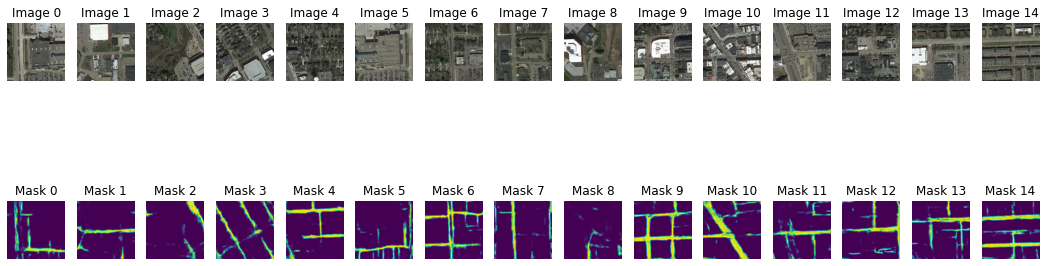

In [27]:
show_first_n(test_images, test_pred_efficientnet, n = 15)

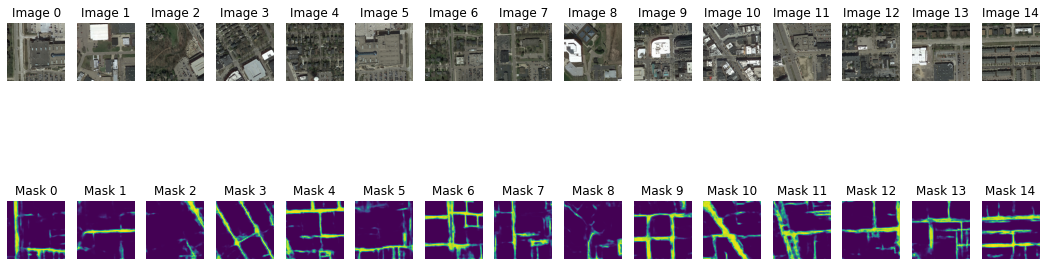

In [28]:
#test_pred_resized = np.reshape(test_pred, (94,608,608))
show_first_n(test_images, test_pred_resnet, n = 15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

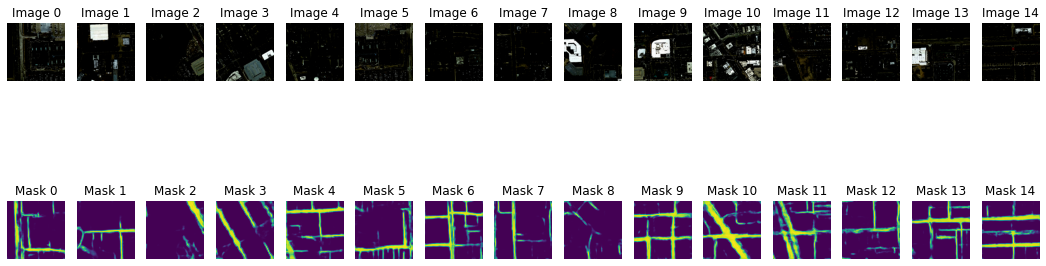

In [29]:
show_first_n(test_images_xception, test_pred_xception, n = 15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

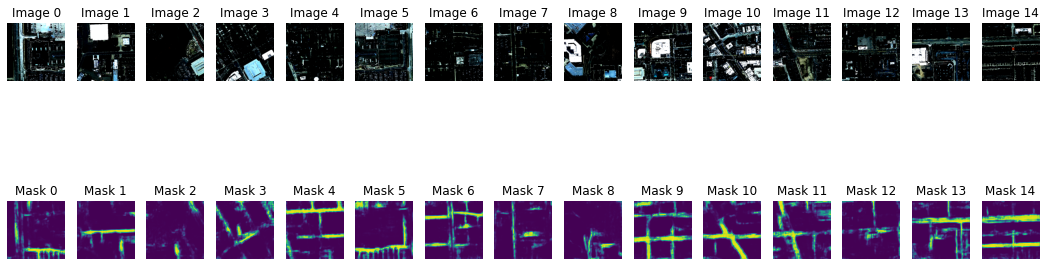

In [30]:
show_first_n(test_images_vgg, test_pred_vgg, n = 15)

ensemble the predictions

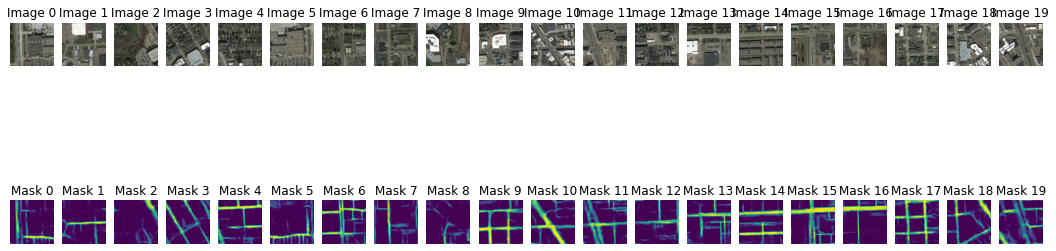

In [39]:
def merge(test_pred_resnet, test_pred_xception,test_pred_vgg, test_pred_efficientnet):
  new_imgs = []
  for indx in range(len(test_pred_resnet)):
      new_imgs.append( np.mean(np.array([test_pred_resnet[indx], test_pred_xception[indx],test_pred_vgg[indx],test_pred_efficientnet[indx]]), axis = 0) )

  return np.array(new_imgs)

test_pred = merge(test_pred_resnet, test_pred_xception,test_pred_vgg, test_pred_efficientnet )


show_first_n(test_images, test_pred, n = 20)

In [40]:
PATCH_SIZE= 16
CUTOFF = 0.25

# now compute labels
test_pred = test_pred.reshape((-1, size[0] // PATCH_SIZE, PATCH_SIZE, size[0] // PATCH_SIZE, PATCH_SIZE))
test_pred = np.moveaxis(test_pred, 2, 3)
test_pred = np.round(np.mean(test_pred, (-1, -2)) > CUTOFF)
create_submission(test_pred, test_filenames, submission_filename='unet_submission.csv')